In [1]:
import nibabel as nb
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
hcp_dir='/data1/users/kwagstyl/bigbrain/NeuralNetworks/hcp/'

In [6]:
annot=nb.load(os.path.join(hcp_dir,'Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii'))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [100]:
thickness = nb.load(os.path.join(hcp_dir,'S1200.corrThickness_MSMAll.32k_fs_LR.dscalar.nii'))
myelin = nb.load(os.path.join(hcp_dir,'S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii'))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [82]:
hemis=['left','right']
fs_hemi=['lh','rh']
mean_bb={}
for k,hemi in enumerate(hemis):
    #read in von economo values
    hcp_parcellation=np.loadtxt('../../data_4_sharing/equivolume_profiles/'+fs_hemi[k]+'.HCP-MMP-1.0.label.txt').astype(int)

    bb_thickness=np.loadtxt('/data1/users/kwagstyl/bigbrain/Hierarchy/thickness_'+hemi+'_total.txt')[:163842]
    mean_bb[hemi]=[]
    for roi in np.unique(hcp_parcellation)[1:]:
        mean_bb[hemi].append(np.mean(bb_thickness[hcp_parcellation==roi]))

In [83]:
annotation=annot.get_data().ravel()[:]

In [84]:
n_vert=int(annotation.shape[0]/2)

In [102]:
mean_hcp={}
myelin_hcp={}
for k,hemi in enumerate(hemis):
    mean_hcp[hemi]=[]
    myelin_hcp[hemi]=[]
    for roi in np.arange(180)+180*k+1:
        mean_hcp[hemi].append(np.mean(thickness.dataobj[:].ravel()[annotation==roi]))
        myelin_hcp[hemi].append(np.mean(myelin.dataobj[:].ravel()[annotation==roi]))

In [86]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [87]:
_,areas=np.unique(annotation,return_counts=True)
for k,hemi in enumerate(hemis):
    print(corr(mean_hcp[hemi],mean_bb[hemi],areas[np.arange(180)+180*k]))

0.620535392002438
0.7532321918132924


In [77]:
labels=nb.freesurfer.read_annot('/data1/users/kwagstyl/wmdist/CIVET/CIVET2_average/label/lh.HCP-MMP1.annot')

In [78]:
len(labels[2])

181

/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


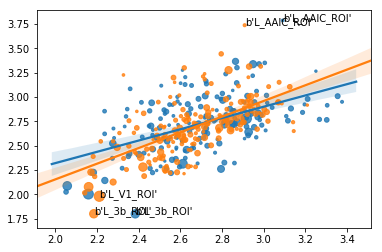

In [126]:
ax=plt.subplot()
for k,hemi in enumerate(hemis):
    
    sns.regplot(mean_bb[hemi],mean_hcp[hemi],scatter_kws={'s': areas[np.arange(180)+180*k]/8}) #,lowess=True)
    diffs=np.subtract(mean_hcp[hemi],mean_bb[hemi])
    for k in np.arange(180):
        if mean_hcp[hemi][k]>3.5 or mean_hcp[hemi][k]<2:
             ax.text(mean_bb[hemi][k],mean_hcp[hemi][k],labels[2][k+1])


0.25378572511634423
-0.009272300371441021


/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


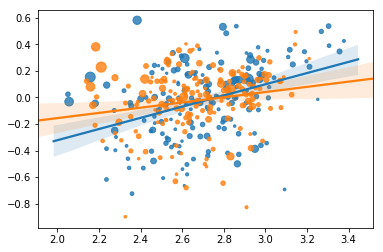

In [125]:
for k,hemi in enumerate(hemis):
    diffs=np.subtract(mean_bb[hemi],mean_hcp[hemi])
    sns.regplot(mean_bb[hemi],diffs,scatter_kws={'s': areas[np.arange(180)+180*k]/8}) #,lowess=True)
    print(corr(mean_bb[hemi],diffs,areas[np.arange(180)+180*k]))

In [171]:
rois=[]
for roi in labels[2][1:]:
    rois.append(np.str(roi[2:-4])[2:-1])

In [148]:
import pandas as pd



In [173]:
df={}
df['ROIs']=rois
df['HCP_left']=mean_hcp['left']
df['HCP_right']=mean_hcp['right']
df['BB_left']=mean_bb['left']
df['BB_right']=mean_bb['right']
df=pd.DataFrame(df)

In [175]:
df.to_csv('../../data_4_sharing/BigBrain_HCP.csv')

In [122]:
#ranked differences
np.array(labels[2])[1:][np.argsort(diffs)]

array([b'L_STGa_ROI', b'L_AAIC_ROI', b'L_PoI1_ROI', b'L_PoI2_ROI',
       b'L_Pir_ROI', b'L_25_ROI', b'L_p24_ROI', b'L_d23ab_ROI',
       b'L_a24_ROI', b'L_s32_ROI', b'L_13l_ROI', b'L_23d_ROI',
       b'L_TGd_ROI', b'L_pOFC_ROI', b'L_11l_ROI', b'L_10v_ROI',
       b'L_AVI_ROI', b'L_PeEc_ROI', b'L_PHA1_ROI', b'L_MI_ROI',
       b'L_a10p_ROI', b'L_10pp_ROI', b'L_47s_ROI', b'L_a47r_ROI',
       b'L_TGv_ROI', b'L_VMV1_ROI', b'L_8BL_ROI', b'L_10r_ROI',
       b'L_d32_ROI', b'L_ProS_ROI', b'L_IFJp_ROI', b'L_47l_ROI',
       b'L_FOP5_ROI', b'L_OFC_ROI', b'L_PHA2_ROI', b'L_55b_ROI',
       b'L_47m_ROI', b'L_IFJa_ROI', b'L_9m_ROI', b'L_31pv_ROI',
       b'L_FOP4_ROI', b'L_STV_ROI', b'L_p32_ROI', b'L_10d_ROI',
       b'L_44_ROI', b'L_8Av_ROI', b'L_Ig_ROI', b'L_46_ROI', b'L_POS1_ROI',
       b'L_PI_ROI', b'L_V4t_ROI', b'L_9p_ROI', b'L_a24pr_ROI',
       b'L_8C_ROI', b'L_23c_ROI', b'L_TE1a_ROI', b'L_p32pr_ROI',
       b'L_a32pr_ROI', b'L_6r_ROI', b'L_TF_ROI', b'L_OP2-3_ROI',
       b'L_IFSp_ROI', 